# **Setting & Introduction**

## **1. Github 연동**

In [1]:
""" github 연동 """
# !git clone https://github.com/ku-sungsukim/2025-LGElec-Day22.git ### colab 사용 시

' github 연동 '

## **2. About Jupyter Notebook**

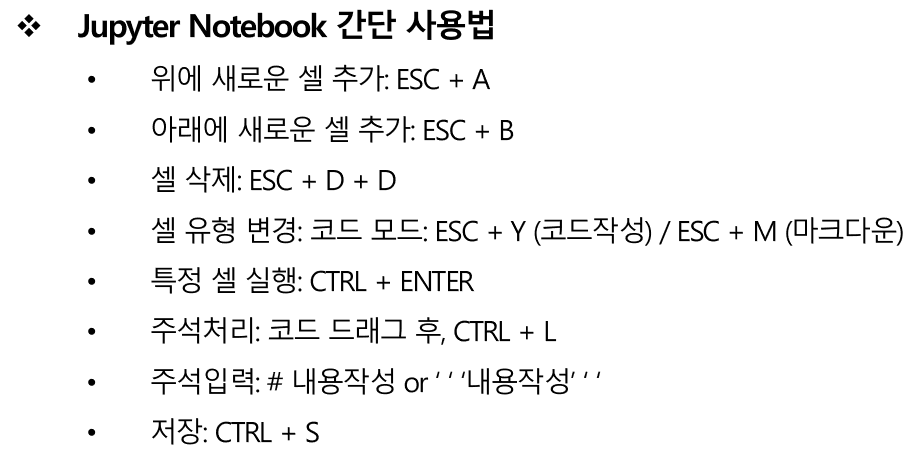

In [2]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/1-Introduction2.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/1-Introduction2.PNG') ### colab 사용 시

## **[Data Balancing & XAI 실습 목차]**
 - (1) Data Balancing (1) - UnderSampling

 - ***(2) Data Balancing (2) - Oversampling √***

 - (3) XAI

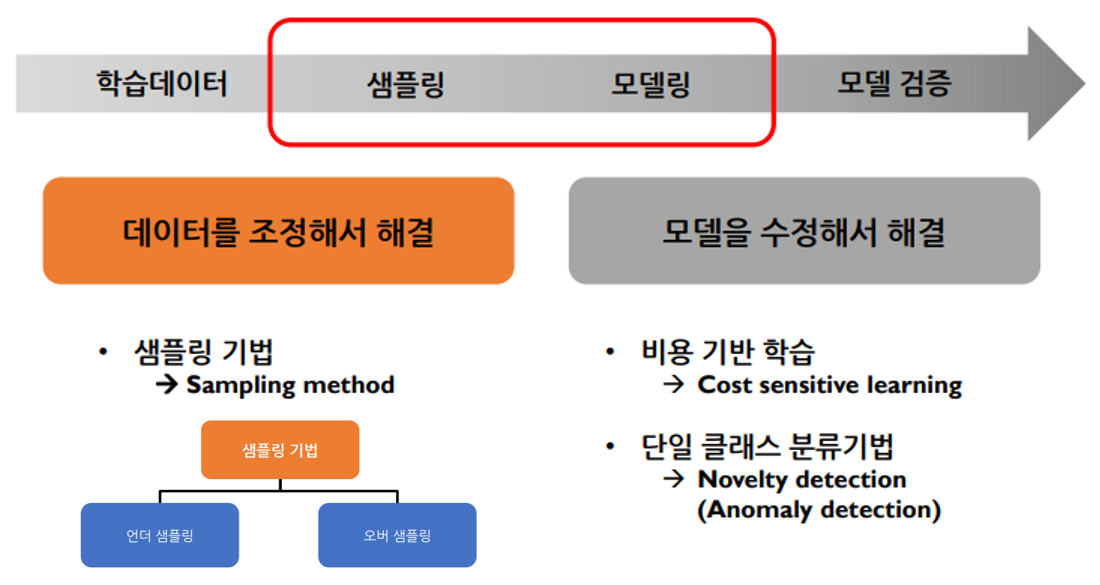

In [3]:
""" 설명 장표 불러오기 """
Image('image/3-DataBalancing1.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/3-DataBalancing1.PNG') ### colab 사용 시

## **[Data Balancing - OverSampling - GAN 목차]**

  - GAN 모델 학습

  - 소수 Class OverSampling

  - 모델 성능 비교

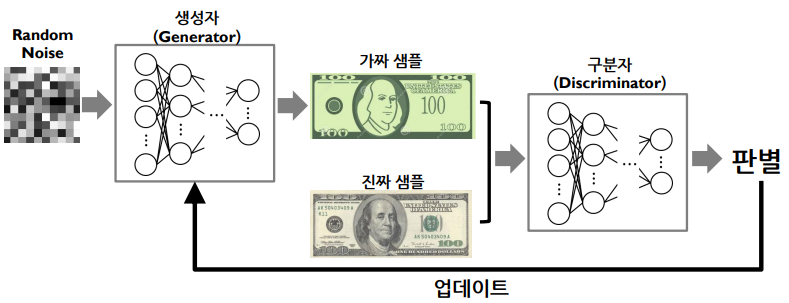

In [4]:
""" 설명 장표 불러오기 """
Image('image/7-GAN1.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/7-GAN1.PNG') ### colab 사용 시

## **0. 모델링 환경 설정**

#### **0-1. 필요 패키지 불러오기**

In [5]:
""" 실습에 필요한 패키지 불러오기 """


""" 기본 연산과 관련된 패키지 """
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm


""" 모델링 및 성능 산출과 관련된 패키지"""
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


""" GAN 모델링 """
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


""" 데이터 시각화 패키지 """
import seaborn as sns
import matplotlib.pyplot as plt


""" 경고 숨기기 """
import warnings
warnings.filterwarnings('ignore')

c:\Users\DMQA\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **0-2. 필요 함수 사전 정의**

In [6]:
""" (1) Confusion Matrix를 시각화하는 함수 """

def plot_confusion_matrix(confusion_matrix, classes):

    ### Confusion Matrix 시각화
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    ### X축 및 Y축 눈금에 Class 표시
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    ### Confusion Matrix 숫자 기입
    thresh = confusion_matrix.max() / 2. ### 폰트 색상 지정을 위한 Threshold
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'), ### 숫자 작성
                 horizontalalignment="center", ### 숫자를 각 행렬 가운데 작성
                 color="white" if confusion_matrix[i, j] > thresh else "black") ### Threshold에 따라 글자 색상 다르게 지정

    ### X축 및 Y축 레이블 표기
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    ### 이미지 크기 최적화 및 시각화
    plt.tight_layout()
    plt.show()

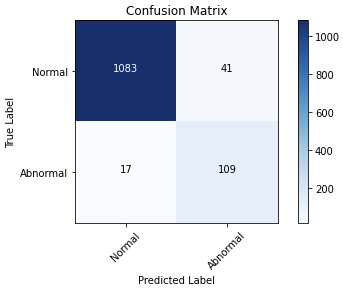

In [7]:
""" 설명 장표 불러오기 """
Image('image/2-Function1.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/2-Function1.PNG') ### colab 사용 시

In [8]:
""" (2) 성능 평가 Metric을 산출하는 함수 """

"""
macro: Class 불균형을 고려한 성능지표
"""

def calculate_classification_metrics(true_labels, predicted_labels):
    
    ### 성능지표 산출
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    ### Log
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    return accuracy, precision, recall, f1

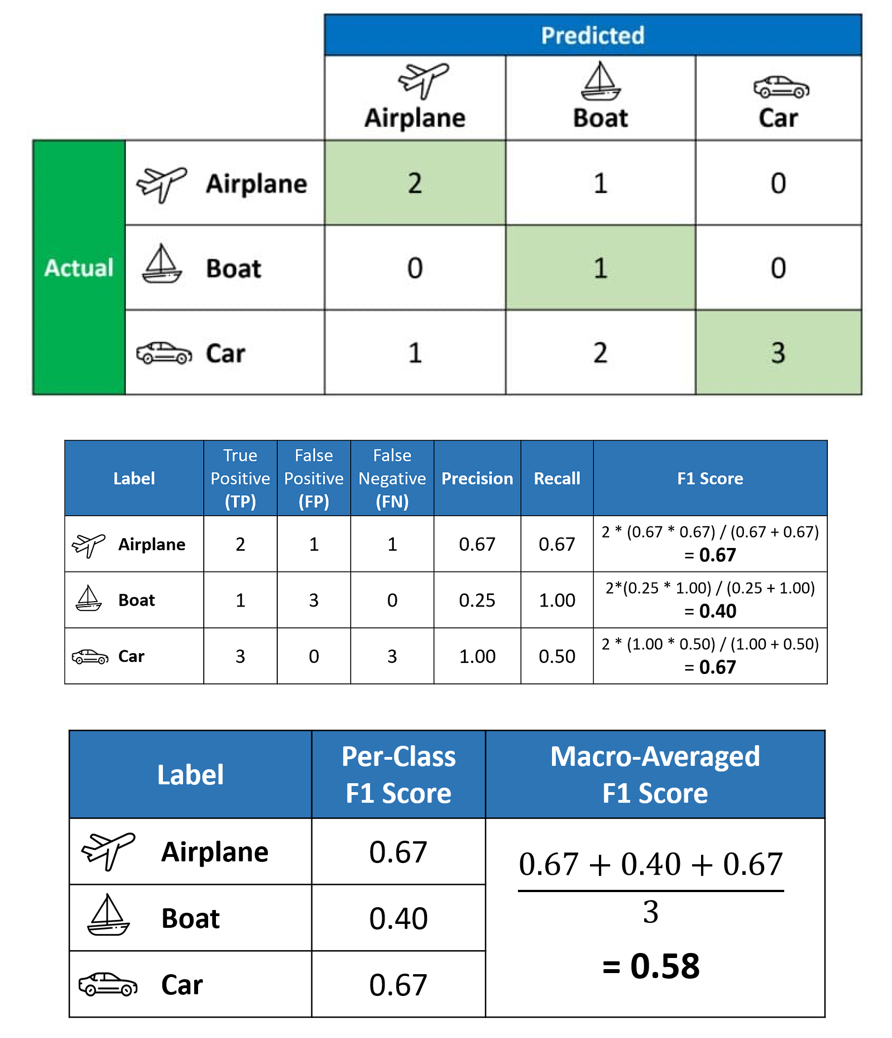

In [9]:
""" 설명 장표 불러오기 """
Image('image/2-Function2.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/2-Function2.PNG') ### colab 사용 시

In [10]:
""" (3) 실습 데이터셋을 생성하는 함수 """
def create_GAN_dataset(n_samples=2000, n_features=256, n_classes=2, weights=(0.8, 0.2), n_cluster=1, class_sep=1, random_state=2024):
    
    ### 데이터셋 생성
    df = make_classification(n_samples=n_samples, ### Instance 개수
                                n_features=n_features, ### 변수 개수
                                n_redundant=0, ### 선형결합으로 생성 가능한 겹치는 변수 개수
                                n_classes=n_classes, ### Class 개수
                                weights=list(weights), ### 클래스 비율
                                n_clusters_per_class=n_cluster, ### Class 당 군집 개수
                                class_sep=class_sep, ### 클래스 군집 간 간격 (클수록 멀어짐)
                                random_state=random_state)
    
    ### X, y 구분
    X = pd.DataFrame(df[0], columns=[f'X{i}' for i in range(1, n_features+1)])
    y = pd.DataFrame(df[1], columns=['y'])
    return X, y

## **1. GAN 모델 학습**

#### **1-1. 실습 데이터 생성**
 - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [11]:
""" 데이터 생성 """
X_syn, y_syn = create_GAN_dataset(n_samples=5000,
                               n_features=256,
                               n_classes=2, 
                               weights=(0.9, 0.1), 
                               n_cluster=1, 
                               class_sep=1, 
                               random_state=2024)

print(X_syn.shape, y_syn.shape)

(5000, 256) (5000, 1)


In [12]:
""" 데이터 형태 확인 """
pd.concat((X_syn, y_syn),axis=1)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X248,X249,X250,X251,X252,X253,X254,X255,X256,y
0,-1.236727,1.810661,0.269814,0.759730,-0.637170,-0.116685,-0.153867,-0.221890,0.713179,0.134482,...,-0.833821,-0.867960,0.254711,-1.389604,2.603830,0.409832,0.675972,-2.343642,-0.296323,0
1,1.204628,0.015548,0.393009,0.050188,-0.274101,-1.222460,-0.009297,0.347870,0.430656,1.231416,...,1.590676,0.344467,-0.372886,0.371968,-0.666464,-1.581206,0.885790,1.455376,-0.242317,0
2,-0.696461,0.488576,0.729301,0.352113,1.600443,-0.701845,1.231809,-1.401036,0.493523,-1.430400,...,1.596512,-0.384060,-0.103767,0.578316,0.377522,0.847870,0.133376,1.637868,0.355098,0
3,0.680626,-0.355473,-0.197281,0.198082,-0.371639,-0.160667,-0.673659,-0.415953,-0.466345,-0.459697,...,-0.847778,-1.121174,1.259768,-1.326776,2.231605,0.045474,1.444481,0.918167,-0.193389,0
4,0.493176,-0.186929,-1.409310,0.264091,-0.140184,1.178291,0.636069,0.036865,-0.309205,-0.203095,...,-0.775727,0.996125,-1.228633,0.286006,-1.292177,-1.993174,-0.540508,0.834193,0.706163,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.742084,-2.401469,-1.059193,-1.462152,-0.665034,-0.635244,0.037753,0.047948,-0.630460,-1.095073,...,1.369093,-0.451521,-0.222046,-1.250002,-0.153022,2.067664,0.181577,0.064377,-0.084864,0
4996,-0.318325,0.538314,1.980017,0.886083,-0.248960,-1.188002,-0.096857,0.006721,0.798101,1.200302,...,-1.975767,0.239597,0.821723,-0.272956,1.192802,-0.573705,-1.015741,-1.675820,-0.681275,0
4997,-0.691345,-0.974921,1.059160,-0.884422,-0.399079,-0.075607,-1.752405,0.013186,-0.023277,-0.458335,...,-0.312138,0.134889,-0.950691,1.243477,0.832836,0.015068,1.020594,-0.827672,-0.445706,0
4998,0.979668,0.539659,-0.611751,0.101640,-0.254042,0.015411,-2.018547,1.638754,0.423748,-0.758963,...,1.220193,-0.896247,0.887547,-0.148535,0.282893,1.403927,0.378052,0.663397,1.694382,0


In [13]:
""" 데이터 불균형 확인 """
print(y_syn.value_counts())

y
0    4479
1     521
Name: count, dtype: int64


In [14]:
""" Train/Test 분할 """
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, random_state=2024)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3750, 256), (1250, 256), (3750, 1), (1250, 1))

#### **1-2. 데이터가 불균형한 상태에서 모델링 (Baseline)**

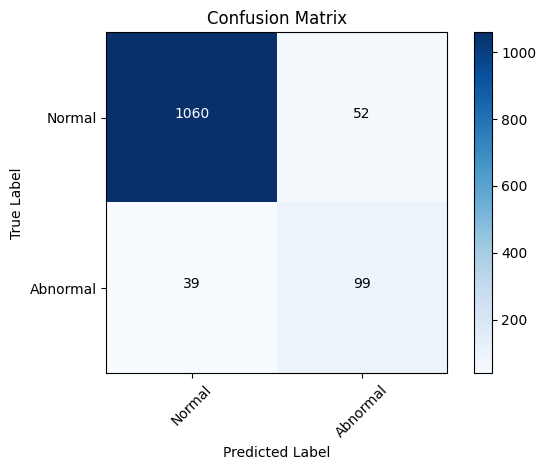

Accuracy : 0.9272
Precision : 0.8101
Recall : 0.8353
F1-score : 0.8220


In [15]:
""" 데이터 불균형한 상태에서 모델링 후, 모델 성능 파악 """

### 모델 Train & Test
dt_tree = tree.DecisionTreeClassifier(random_state=2024)
dt_tree.fit(X_train, y_train)
y_pred_test = dt_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_baseline = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

#### **1-3. GAN 모델 학습**

 - Dataset과 DataLoader 정의

 - 모델 구조 정의

 - GAN 모델 학습 

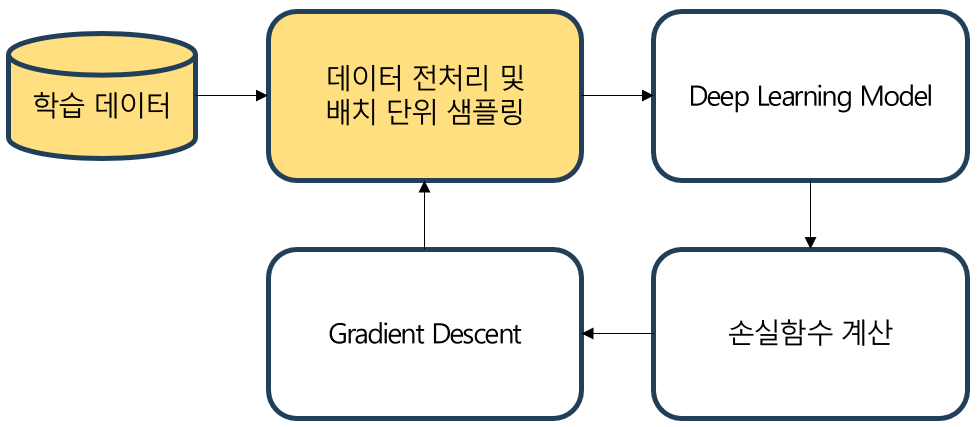

In [16]:
""" 설명 장표 불러오기 """
Image('image/8-TrainingPhase1.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/8-TrainingPhase1.PNG') ### colab 사용 시

In [17]:
""" 1. pytorch 스타일 dataset 정의 """
class CustomDataset(Dataset):
    def __init__(self, X):
        super().__init__()
        
        self.X = X.to_numpy()
        
    def __getitem__(self, index):
        X = torch.FloatTensor(self.X[index])
        return X
    
    def __len__(self):
        return len(self.X)

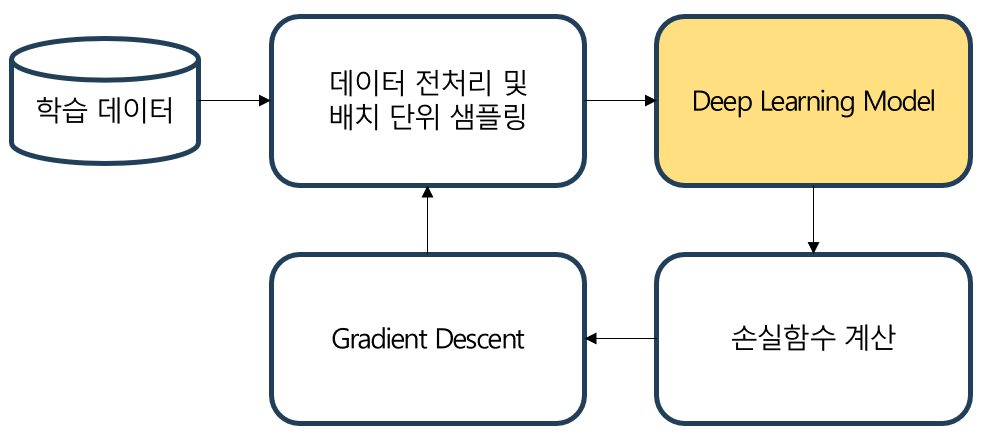

In [18]:
""" 설명 장표 불러오기 """
Image('image/8-TrainingPhase2.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/8-TrainingPhase2.PNG') ### colab 사용 시

In [19]:
""" 2. pytorch 스타일 모델 구조 정의 """

### Generator 구조
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = F.leaky_relu(self.fc3(x), 0.1)
        return torch.tanh(x)
    

### Discriminator 구조
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)

        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)

        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(x)

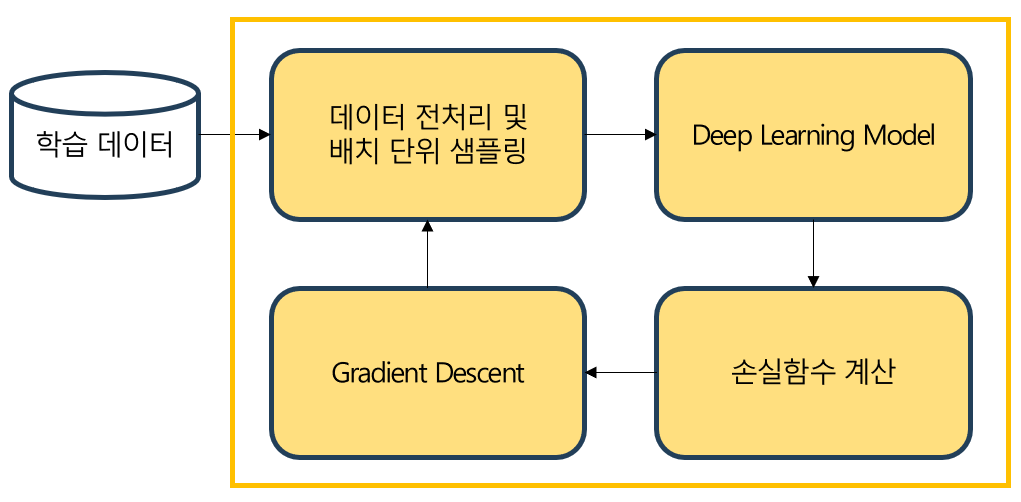

In [20]:
""" 설명 장표 불러오기 """
Image('image/8-TrainingPhase3.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/8-TrainingPhase3.PNG') ### colab 사용 시

In [21]:
""" 3. GAN 모델 학습 """
### 소수 Class만 필터링 후, 학습 데이터셋 구축
X_minor = X_train[y_train['y'] == 1]
mino_datasets = CustomDataset(X_minor)
dataloader = DataLoader(mino_datasets,
                        batch_size=64, 
                        sampler=torch.utils.data.RandomSampler(mino_datasets),
                        drop_last=True)

### 모델 하이퍼파라미터 정의
g_input_dim = 100
g_hidden_dim = 192
g_output_dim = 256 
d_input_dim = 256 
d_hidden_dim = 192
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 모델 정의
G = Generator(g_input_dim, g_hidden_dim, g_output_dim).to(device)
D = Discriminator(d_input_dim, d_hidden_dim).to(device)

### 목적함수 정의
criterion = nn.BCELoss()
criterion = criterion.to(device)

### Optimizer 정의
optimizer_g = optim.Adam(G.parameters(), lr=0.0002)
optimizer_d = optim.Adam(D.parameters(), lr=0.0002)

### 모델 학습 
G.train()
D.train()
epochs = 100
g_losses, d_losses = [], []
for epoch in range(epochs):
    with tqdm(total=len(dataloader)) as tbar:
        for idx, X in enumerate(dataloader):
            
            ### 데이터 불러오기
            X = X.to(device=device)
            N, _ = X.size()

            ### 진짜와 가짜 Label 설정
            label_real = torch.ones(size=(N,1)).to(device=device)
            label_fake = torch.zeros(size=(N,1)).to(device=device)
            
            ### Discriminator 학습
            optimizer_d.zero_grad()
            output_real = D(X)
            d_loss_real = criterion(output_real, label_real) ### 실제 이미지에 대한 Loss

            z = torch.randn(N, g_input_dim).to(device=device)
            fake_imgs = G(z) ### 이미지 생성
            output_fake = D(fake_imgs)
            d_loss_fake = criterion(output_fake, label_fake) ### 생성된 가짜 이미지에 대한 Loss

            d_loss_total = d_loss_fake + d_loss_real  
            d_loss_total.backward()
            optimizer_d.step()
            
            d_losses.append(d_loss_total.item())
            
            # Generator 학습
            optimizer_g.zero_grad()
            z = torch.randn(N, g_input_dim).to(device=device)
            fake_imgs = G(z) ### 가짜 이미지 생성
            output_fake = D(fake_imgs) ### 생성된 이미지의 진짜 여부 판별

            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            optimizer_g.step()

            g_losses.append(g_loss.item())

            ### Log
            tbar.set_description('Epoch [{:3d}/{:3d}], d_loss: {:.4f}, g_loss: {:.4f}'.format(epoch+1, epochs, d_loss_total.item(), g_loss.item()))
            tbar.update(1)

Epoch [100/100], d_loss: 5.0000, g_loss: 0.5563: 100%|██████████| 5/5 [00:00<00:00, 138.96it/s]


<Axes: >

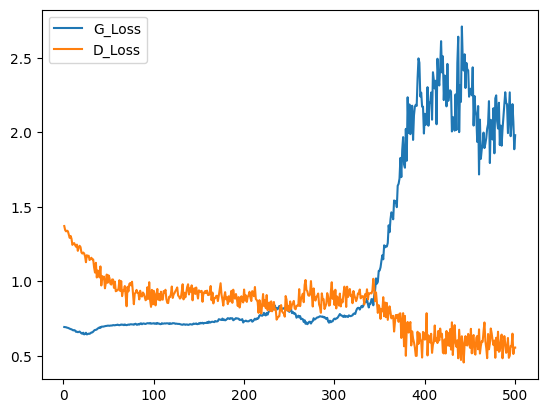

In [22]:
""" Generator와 Discriminator의 Loss 시각화"""
sns.lineplot(x=range(1, len(g_losses)+1), y=g_losses, label='G_Loss')
sns.lineplot(x=range(1, len(d_losses)+1), y=d_losses, label='D_Loss')

#### **1-4. 소수 Class Oversampling**

 - GAN 모델을 활용하여 데이터 생성

In [23]:
""" GAN 모델을 Inference하여 OverSampling """

### GAN 모델 Inference: Noise를 넣어 데이터 생성
n_sampling = 2000
G.eval()
with torch.no_grad():
    z = torch.randn(n_sampling, g_input_dim).to(device=device)
    X_gan = G(z)

### 실제 데이터와 유사한 형태로 정제
X_gan = X_gan.cpu().numpy()
y_gan = np.ones(shape=(len(X_gan),1))

X_gan.shape, y_gan.shape

((2000, 256), (2000, 1))

In [24]:
""" 기존 데이터와 합치기 """
X_resampled = np.concatenate([X_train, X_gan], axis=0)
y_resampled = np.concatenate([y_train, y_gan], axis=0)

print(f'X shape : {X_train.shape} ||| After Sampling : {X_resampled.shape}')

X shape : (3750, 256) ||| After Sampling : (5750, 256)


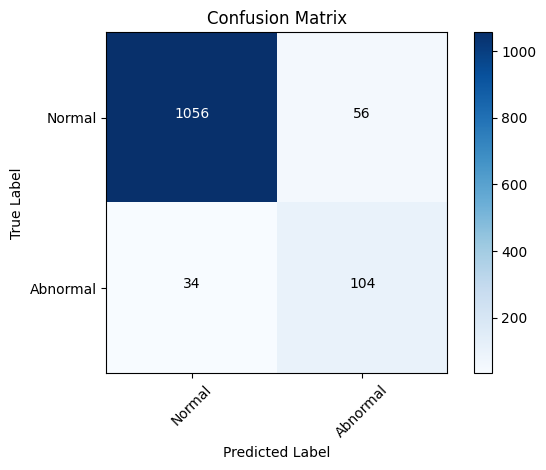

Accuracy : 0.9280
Precision : 0.8094
Recall : 0.8516
F1-score : 0.8286


In [25]:
""" GAN 기반 OverSampling 후, 모델 성능 파악 """

### 모델 Train & Test
dt_tree = tree.DecisionTreeClassifier(random_state=2024)
dt_tree.fit(X_resampled, y_resampled)
y_pred_test = dt_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_gan = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_gan, classes)
_, _, _, f1_gan = calculate_classification_metrics(y_test, y_pred_test)

#### **1-5. Baseline과 모델 성능 비교**

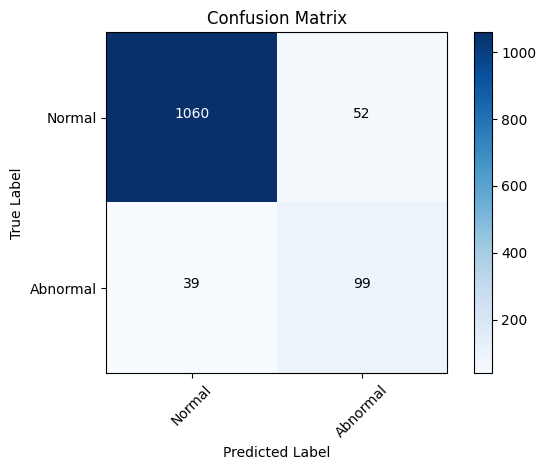

Accuracy : 0.9272
Precision : 0.8101
Recall : 0.8353
F1-score : 0.8220


In [26]:
""" Baseline 모델 성능 """

### 모델 Train & Test
dt_tree = tree.DecisionTreeClassifier(random_state=2024)
dt_tree.fit(X_train, y_train)
y_pred_test = dt_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_baseline = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)